In [23]:
#Facebook's Prophet library already included in Colab
#!pip install fbprophet
#Install World Weather Online library and import other dependencies:
#!pip install wwo-hist
import pandas as pd
import numpy as np
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from datetime import datetime, timedelta
import requests
from wwo_hist import retrieve_hist_data
from datetime import date
import pytz
%matplotlib inline

In [24]:
#Import our visit data from an excel file on Dropbox
df = pd.read_excel('https://www.dropbox.com/s/fif8x662vpmnsma/daily-visits-incl-19-12-17.xlsx?dl=1')
#Prophet only accepts these columns names:
df.columns = ['ds','y']
#Some of the timestamp day occasionally is off by a few milliseconds, not sure why, but we'll fix it by rounding:
df['ds'] = df['ds'].dt.round('15min')
#I've saved the data as hourly visits, so to convert to daily visits we group by date:
df = df.groupby([df['ds'].dt.date]).sum()
df = df.reset_index()
df = df.dropna()
df.tail()

,ds,y
2781,2019-12-13,241
2782,2019-12-14,223
2783,2019-12-15,214
2784,2019-12-16,316
2785,2019-12-17,291


In [25]:
#Import our stat days excel file, split them by RAMQ vs JGH
stat_days_df = pd.read_excel('https://www.dropbox.com/s/6kv67yhuv6f3b3h/statdays.xlsx?dl=1')
print(stat_days_df.head())
ramq_stat_days = stat_days_df['RAMQ']
ramq_stat_days = ramq_stat_days.dropna()
print(ramq_stat_days.head())
jgh_stat_days = stat_days_df['JGH']
jgh_stat_days = jgh_stat_days.dropna()
print(jgh_stat_days.head())

        RAMQ        JGH
0 2015-05-18 2015-05-18
1 2015-06-24 2015-06-24
2 2015-07-01 2015-07-01
3 2015-09-07 2015-09-07
4 2015-10-12 2015-10-12
0   2015-05-18
1   2015-06-24
2   2015-07-01
3   2015-09-07
4   2015-10-12
Name: RAMQ, dtype: datetime64[ns]
0   2015-05-18
1   2015-06-24
2   2015-07-01
3   2015-09-07
4   2015-10-12
Name: JGH, dtype: datetime64[ns]


In [26]:
#Save the stat day data in the format expected by Prophet
ramq_stat_days = pd.DataFrame({
  'holiday': 'ramq',
  'ds': ramq_stat_days.to_list(),
  'lower_window': 0,
  'upper_window': 1,
})
print(ramq_stat_days.head())
jgh_stat_days = pd.DataFrame({
  'holiday': 'jgh',
  'ds': jgh_stat_days.to_list(),
  'lower_window': 0,
  'upper_window': 1,
})
print(jgh_stat_days.head())
holidays = pd.concat((ramq_stat_days, jgh_stat_days))
print(holidays.sample(10))

  holiday         ds  lower_window  upper_window
0    ramq 2015-05-18             0             1
1    ramq 2015-06-24             0             1
2    ramq 2015-07-01             0             1
3    ramq 2015-09-07             0             1
4    ramq 2015-10-12             0             1
  holiday         ds  lower_window  upper_window
0     jgh 2015-05-18             0             1
1     jgh 2015-06-24             0             1
2     jgh 2015-07-01             0             1
3     jgh 2015-09-07             0             1
4     jgh 2015-10-12             0             1
   holiday         ds  lower_window  upper_window
45     jgh 2018-12-25             0             1
18     jgh 2016-10-03             0             1
69    ramq 2020-10-12             0             1
57     jgh 2019-09-30             0             1
60     jgh 2019-12-31             0             1
1      jgh 2015-06-24             0             1
46    ramq 2018-12-26             0             1
30     jgh 2

In [27]:
#Get all Montreal Canadiens games in our time frame (2012-present) from the NHL's REST API
resp = requests.get('https://statsapi.web.nhl.com/api/v1/schedule?teamId=8&startDate=2012-05-01&endDate=2020-05-01')
if resp.status_code != 200:
    raise ApiError('GET /tasks/ {}'.format(resp.status_code))

games = []
for date in resp.json()['dates']:
  for g in date['games']:
    for hour in [0,1,2,3]:
          toAppend = {'dateTime':datetime.strptime(g['gameDate'], "%Y-%m-%dT%H:%M:%SZ")-timedelta(hours=5-hour),'homeTeam':g['teams']['home']['team']['name'], 'awayTeam':g['teams']['away']['team']['name']}
          toAppend['awayScore'] = g['teams']['away']['score']
          toAppend['homeScore'] = g['teams']['home']['score']
          games.append(toAppend)
hockey_df = pd.DataFrame(games)
hockey_df['dateTime'] = hockey_df['dateTime'].dt.date
print(hockey_df.sample(5))

#Separate the games by Home or Away
home_hockey_df = hockey_df[hockey_df['homeTeam'].isin(['Montréal Canadiens','MontrÃ©al Canadiens'])]
print(home_hockey_df.sample(5))

away_hockey_df = hockey_df[hockey_df['awayTeam'].isin(['Montréal Canadiens','MontrÃ©al Canadiens'])]
print(away_hockey_df.sample(5))

#Format them as Prophet expects
home_hockey = pd.DataFrame({
  'holiday': 'homeHockey',
  'ds': pd.to_datetime(home_hockey_df['dateTime']),
  'lower_window': 0,
  'upper_window': 1,
})

away_hockey = pd.DataFrame({
  'holiday': 'awayHockey',
  'ds': pd.to_datetime(away_hockey_df['dateTime']),
  'lower_window': 0,
  'upper_window': 1,
})

#Add the hockey games to our stat day data
holidays = pd.concat((home_hockey, away_hockey, ramq_stat_days, jgh_stat_days))
print(holidays.sample(10))

        dateTime             homeTeam            awayTeam  awayScore  \
2235  2018-11-14      Edmonton Oilers  Montréal Canadiens          2   
2169  2018-10-06  Pittsburgh Penguins  Montréal Canadiens          5   
2672  2019-12-29     Florida Panthers  Montréal Canadiens          0   
1088  2015-10-17   Montréal Canadiens   Detroit Red Wings          1   
916   2015-03-04        Anaheim Ducks  Montréal Canadiens          1   

      homeScore  
2235          6  
2169          1  
2672          0  
1088          4  
916           3  
        dateTime            homeTeam             awayTeam  awayScore  \
637   2014-09-23  Montréal Canadiens        Boston Bruins          2   
411   2014-01-04  Montréal Canadiens      Ottawa Senators          4   
178   2013-04-20  Montréal Canadiens  Washington Capitals          5   
1548  2016-12-20  Montréal Canadiens        Anaheim Ducks          1   
2776  2020-02-25  Montréal Canadiens    Vancouver Canucks          0   

      homeScore  
637     

In [28]:
#Load our weather data from Dropbox
weather_df = pd.read_csv('https://www.dropbox.com/s/p4g902q6hpgwju2/hist-hourly-weather-incl-19-12-13.csv?dl=1')
weather_df['date_time']=pd.to_datetime(weather_df['date_time'])
#The Moon and Sunrise/set data are not numerical, so we'll drop them for this analysis
weather_df = weather_df.drop(['moonrise','moonset','sunrise','sunset'],axis=1)
weather_df = weather_df.rename(columns={"date_time": "ds"})
weather_df.tail()

,ds,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,uvIndex.1,moon_illumination,DewPointC,FeelsLikeC,...,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
2778,2019-12-09,3,-3,0.0,3.3,1,1,84,2,-2,...,-2,28,100,96,19.2,1011,3,8,159,16
2779,2019-12-10,7,-5,0.0,3.3,1,1,92,-2,-3,...,-3,35,72,75,4.6,1005,7,9,250,22
2780,2019-12-11,-2,-7,0.0,8.7,1,1,99,-14,-9,...,-9,20,43,48,1.1,1022,-2,8,182,15
2781,2019-12-12,-5,-12,0.0,8.7,1,1,100,-13,-12,...,-12,23,42,60,0.0,1034,-5,10,239,15
2782,2019-12-13,1,-4,0.0,8.7,1,1,87,-5,-5,...,-5,22,59,75,0.3,1026,1,9,169,13


In [29]:
#Fetch whicher days are missing, and 2 days into the future (weather forecast), which is the maximum the WWO API let's us access through the this API
#The Data is saved as a csv file called 'Montreal'
frequency = 24
start_date = (weather_df.ds.max()+timedelta(days=1)).date().strftime("%d-%b-%Y").upper()
end_date = (datetime.now(pytz.utc)+timedelta(days=2)).astimezone(pytz.timezone('US/Eastern')).date().strftime("%d-%b-%Y").upper()
api_key = '3d51d04f983a478e90f164916191012'
location_list = ['Montreal']
hist_weather_data = retrieve_hist_data(api_key,
                                location_list,
                                start_date,
                                end_date,
                                frequency,
                                location_label = False,
                                export_csv = True,
                                store_df = True)



Retrieving weather data for Montreal


Currently retrieving data for Montreal: from 2019-12-14 to 2019-12-24
Time elapsed (hh:mm:ss.ms) 0:00:00.446672


export Montreal completed!




In [30]:
#Load the missing weather data from the CSV file
missing_weather_df = pd.read_csv('Montreal.csv')
missing_weather_df['date_time']=pd.to_datetime(missing_weather_df['date_time'])
missing_weather_df = missing_weather_df.drop(['moonrise','moonset','sunrise','sunset'],axis=1)
missing_weather_df = missing_weather_df.rename(columns={"date_time": "ds"})
missing_weather_df

,ds,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,uvIndex.1,moon_illumination,DewPointC,FeelsLikeC,...,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
0,2019-12-14,4,1,0.0,3.3,1,1,79,2,-1,...,-1,26,97,97,27.1,1000,4,7,54,15
1,2019-12-15,0,-8,0.0,3.3,1,1,72,-16,-16,...,-16,35,0,53,0.0,1016,0,10,0,26
2,2019-12-16,-4,-9,0.0,8.7,1,1,65,-13,-12,...,-12,21,33,59,0.0,1022,-4,10,253,15
3,2019-12-17,-2,-5,2.2,3.3,1,1,58,-7,-6,...,-6,9,74,80,3.4,1013,-2,7,55,6
4,2019-12-18,-3,-13,2.2,3.3,1,1,50,-8,-10,...,-10,19,94,87,2.7,1007,-3,5,249,14
5,2019-12-19,-12,-16,0.0,5.1,1,1,43,-18,-24,...,-24,35,75,70,0.0,1023,-12,10,267,25
6,2019-12-20,-9,-15,0.0,8.7,1,1,36,-14,-17,...,-17,15,24,79,0.0,1036,-9,10,259,11
7,2019-12-21,-7,-11,0.0,3.3,1,1,28,-11,-12,...,-12,8,71,86,0.0,1034,-7,10,67,5
8,2019-12-22,2,-7,0.0,3.3,1,1,21,-3,-5,...,-5,18,95,89,0.0,1021,2,9,228,10
9,2019-12-23,5,-1,0.0,3.3,1,1,14,0,-2,...,-2,31,78,84,0.0,1013,5,10,240,19


In [31]:
#Concatenate the old weather data with the missing weather data
final_weather_df = pd.concat([weather_df, missing_weather_df])
final_weather_df.tail(14)

,ds,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,uvIndex.1,moon_illumination,DewPointC,FeelsLikeC,...,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
2780,2019-12-11,-2,-7,0.0,8.7,1,1,99,-14,-9,...,-9,20,43,48,1.1,1022,-2,8,182,15
2781,2019-12-12,-5,-12,0.0,8.7,1,1,100,-13,-12,...,-12,23,42,60,0.0,1034,-5,10,239,15
2782,2019-12-13,1,-4,0.0,8.7,1,1,87,-5,-5,...,-5,22,59,75,0.3,1026,1,9,169,13
0,2019-12-14,4,1,0.0,3.3,1,1,79,2,-1,...,-1,26,97,97,27.1,1000,4,7,54,15
1,2019-12-15,0,-8,0.0,3.3,1,1,72,-16,-16,...,-16,35,0,53,0.0,1016,0,10,0,26
2,2019-12-16,-4,-9,0.0,8.7,1,1,65,-13,-12,...,-12,21,33,59,0.0,1022,-4,10,253,15
3,2019-12-17,-2,-5,2.2,3.3,1,1,58,-7,-6,...,-6,9,74,80,3.4,1013,-2,7,55,6
4,2019-12-18,-3,-13,2.2,3.3,1,1,50,-8,-10,...,-10,19,94,87,2.7,1007,-3,5,249,14
5,2019-12-19,-12,-16,0.0,5.1,1,1,43,-18,-24,...,-24,35,75,70,0.0,1023,-12,10,267,25
6,2019-12-20,-9,-15,0.0,8.7,1,1,36,-14,-17,...,-17,15,24,79,0.0,1036,-9,10,259,11


In [32]:
#Make a list of our weather variables
regressors = final_weather_df.columns.to_list()
regressors.remove('ds')
print(regressors)
print(len(regressors))

['maxtempC', 'mintempC', 'totalSnow_cm', 'sunHour', 'uvIndex', 'uvIndex.1', 'moon_illumination', 'DewPointC', 'FeelsLikeC', 'HeatIndexC', 'WindChillC', 'WindGustKmph', 'cloudcover', 'humidity', 'precipMM', 'pressure', 'tempC', 'visibility', 'winddirDegree', 'windspeedKmph']
20


In [33]:
#Some final formatting our our data to be able to merge it with the weather data
df.ds = pd.to_datetime(df.ds)
final_df = pd.merge(df, final_weather_df, on='ds')
final_df.tail()

,ds,y,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,uvIndex.1,moon_illumination,DewPointC,...,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
2781,2019-12-13,241,1,-4,0.0,8.7,1,1,87,-5,...,-5,22,59,75,0.3,1026,1,9,169,13
2782,2019-12-14,223,4,1,0.0,3.3,1,1,79,2,...,-1,26,97,97,27.1,1000,4,7,54,15
2783,2019-12-15,214,0,-8,0.0,3.3,1,1,72,-16,...,-16,35,0,53,0.0,1016,0,10,0,26
2784,2019-12-16,316,-4,-9,0.0,8.7,1,1,65,-13,...,-12,21,33,59,0.0,1022,-4,10,253,15
2785,2019-12-17,291,-2,-5,2.2,3.3,1,1,58,-7,...,-6,9,74,80,3.4,1013,-2,7,55,6


In [34]:
#Instantiate our model with our stat day and hockey variables saved in the 'holidays' dataframe
m = Prophet(holidays=holidays)
#Add Prophet's built-in holidays for Canada
m.add_country_holidays(country_name='CA')
#Add our 20 weather variables as regressors
for regressor in regressors:
  m.add_regressor(regressor)
#Fit our model to our data
m.fit(final_df)
#Fit our model to data from before 2019
#m.fit(final_df[final_df.ds<'2019-01-01'])

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/anaconda3/envs/prophet/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [35]:
forecast = m.predict(final_weather_df)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

             ds        yhat  yhat_lower  yhat_upper
2789 2019-12-20  264.363148  245.318729  285.055880
2790 2019-12-21  227.959740  207.892588  248.357255
2791 2019-12-22  238.789885  219.310569  258.597532
2792 2019-12-23  310.694153  292.004057  329.780140
2793 2019-12-24  267.845761  247.128567  287.120530


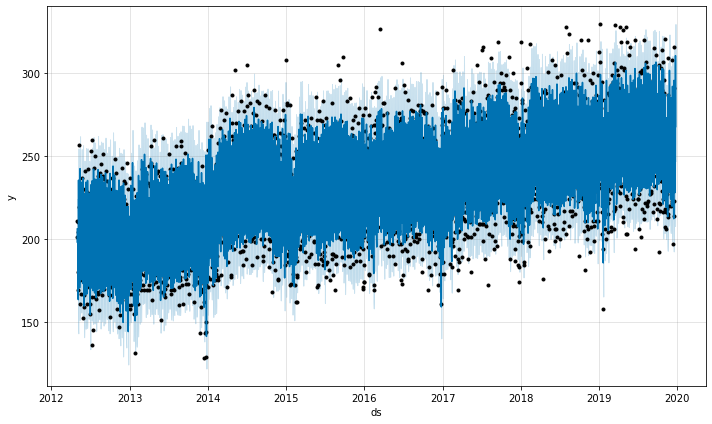

In [36]:
fig1 = m.plot(forecast)

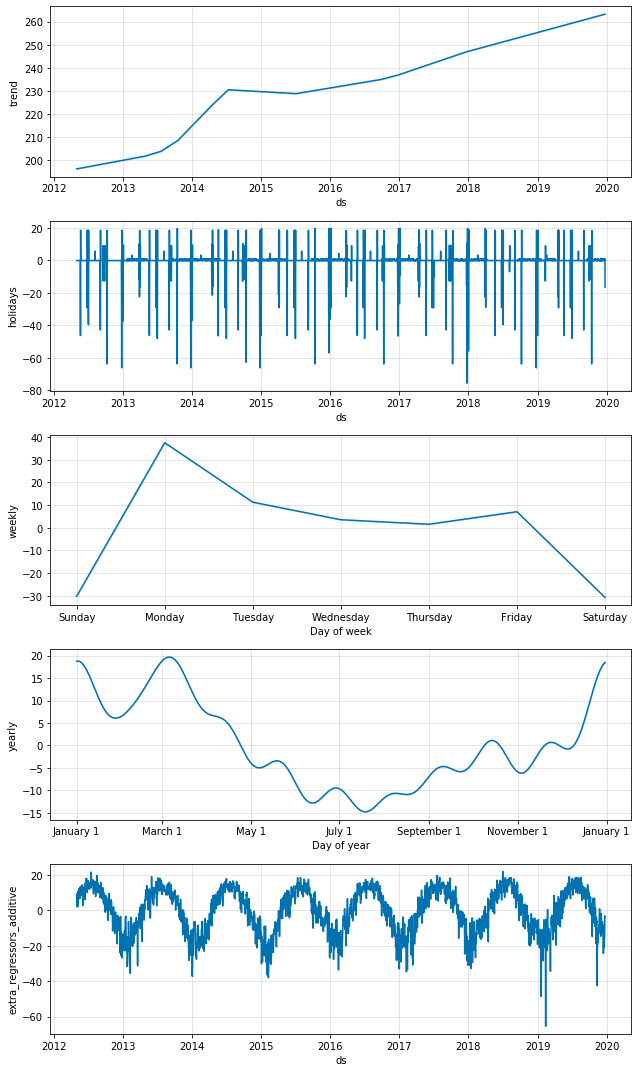

In [37]:
fig2 = m.plot_components(forecast)

In [39]:
import pickle
pkl_path = "jgh-prophet-19-12-22.pkl"
with open(pkl_path, "wb") as f:
    # Pickle the 'Prophet' model using the highest protocol available.
    pickle.dump(m, f)

In [40]:
# read the Prophet model object
with open(pkl_path, 'rb') as f:
    m = pickle.load(f)

In [41]:
m

In [44]:
frequency = 24
start_date = (datetime.now(pytz.utc)).astimezone(pytz.timezone('US/Eastern')).date().strftime("%d-%b-%Y").upper()
end_date = (datetime.now(pytz.utc)+timedelta(days=2)).astimezone(pytz.timezone('US/Eastern')).date().strftime("%d-%b-%Y").upper()
api_key = '3d51d04f983a478e90f164916191012'
location_list = ['Montreal']
hist_weather_data = retrieve_hist_data(api_key,
                                location_list,
                                start_date,
                                end_date,
                                frequency,
                                location_label = False,
                                export_csv = False,
                                store_df = True)



Retrieving weather data for Montreal


Currently retrieving data for Montreal: from 2019-12-22 to 2019-12-24
Time elapsed (hh:mm:ss.ms) 0:00:00.305785


In [49]:
weather_forecast = hist_weather_data[0]

In [50]:
weather_forecast

,date_time,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,uvIndex,moon_illumination,moonrise,moonset,...,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
0,2019-12-22,2,-7,0.0,3.3,1,1,21,03:19 AM,01:59 PM,...,-5,18,95,89,0.0,1021,2,9,228,10
0,2019-12-23,5,-1,0.0,3.3,1,1,14,04:33 AM,02:32 PM,...,-2,31,78,84,0.0,1013,5,10,240,19
0,2019-12-24,-2,-4,0.0,8.7,1,1,7,05:46 AM,03:10 PM,...,-6,8,32,59,0.0,1024,-2,10,249,6


In [51]:
weather_forecast['date_time']=pd.to_datetime(weather_forecast['date_time'])
weather_forecast = weather_forecast.drop(['moonrise','moonset','sunrise','sunset'],axis=1)
weather_forecast = weather_forecast.rename(columns={"date_time": "ds"})
weather_forecast

,ds,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,uvIndex,moon_illumination,DewPointC,FeelsLikeC,...,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
0,2019-12-22,2,-7,0.0,3.3,1,1,21,-3,-5,...,-5,18,95,89,0.0,1021,2,9,228,10
0,2019-12-23,5,-1,0.0,3.3,1,1,14,-0,-2,...,-2,31,78,84,0.0,1013,5,10,240,19
0,2019-12-24,-2,-4,0.0,8.7,1,1,7,-10,-6,...,-6,8,32,59,0.0,1024,-2,10,249,6


In [52]:
weather_forecast.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3 entries, 0 to 0
Data columns (total 21 columns):
ds                   3 non-null datetime64[ns]
maxtempC             3 non-null object
mintempC             3 non-null object
totalSnow_cm         3 non-null object
sunHour              3 non-null object
uvIndex              3 non-null object
uvIndex              3 non-null object
moon_illumination    3 non-null object
DewPointC            3 non-null object
FeelsLikeC           3 non-null object
HeatIndexC           3 non-null object
WindChillC           3 non-null object
WindGustKmph         3 non-null object
cloudcover           3 non-null object
humidity             3 non-null object
precipMM             3 non-null object
pressure             3 non-null object
tempC                3 non-null object
visibility           3 non-null object
winddirDegree        3 non-null object
windspeedKmph        3 non-null object
dtypes: datetime64[ns](1), object(20)
memory usage: 528.0+ bytes


In [53]:
final_weather_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2794 entries, 0 to 10
Data columns (total 21 columns):
ds                   2794 non-null datetime64[ns]
maxtempC             2794 non-null int64
mintempC             2794 non-null int64
totalSnow_cm         2794 non-null float64
sunHour              2794 non-null float64
uvIndex              2794 non-null int64
uvIndex.1            2794 non-null int64
moon_illumination    2794 non-null int64
DewPointC            2794 non-null int64
FeelsLikeC           2794 non-null int64
HeatIndexC           2794 non-null int64
WindChillC           2794 non-null int64
WindGustKmph         2794 non-null int64
cloudcover           2794 non-null int64
humidity             2794 non-null int64
precipMM             2794 non-null float64
pressure             2794 non-null int64
tempC                2794 non-null int64
visibility           2794 non-null int64
winddirDegree        2794 non-null int64
windspeedKmph        2794 non-null int64
dtypes: datetime64[